# **CNN-CT-BRAIN 🧠**

In [1]:
# Importamos todas las librerias de nuestro proyecto
import cv2
import random
import os as os
import numpy as np
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


1. Definimos las semillas y el directorio

In [2]:
# Si usamos google colab
#from google.colab import drive
#drive.mount("/content/drive")
# En caso contrario comentar lo de arriba

seed = 2027
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

Definimos un metodo auxiliar para cargar y procesar las imagenes

In [3]:
def load_and_preprocess_images(base_dir):
    image_paths = []
    classes = []

    # Recorrer cada clase en el directorio base
    for cls in os.listdir(base_dir):
        class_path = os.path.join(base_dir, cls)

        # Verificar si es un directorio
        if os.path.isdir(class_path):
            # Recorrer cada archivo en el directorio de la clase
            for file_name in os.listdir(class_path):
                # Filtrar archivos con extensión 'jpg'
                if file_name.split('.')[-1] == 'jpg':
                    image_paths.append(os.path.join(class_path, file_name))
                    classes.append(cls)

    # Codificación de etiquetas
    le = LabelEncoder()
    y = le.fit_transform(classes)
    y = np.array(y)

    inputs = []

    # Cargar imágenes y convertirlas a arrays
    for i in tqdm(image_paths):
        image = load_img(i)
        img_array = img_to_array(image)
        inputs.append(img_array)

    X = np.array(inputs)

    return X, y


2. Cargamos las imagenes y dividimos los datos

In [4]:
# direccion de google drive (Cambiar en ejecucion en local)
#base_dir = "/content/drive/MyDrive/Colab Notebooks/"
base_dir ="archive/files/"
X, y = load_and_preprocess_images(base_dir)

# Dividir los datos en conjuntos de entrenamiento y prueba
num_classes = len(np.unique(y))
train_test_split(X, y, test_size = 0.2)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

# Convertir etiquetas a su forma one-hot
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# Preprocesar los datos (escalarlos entre 0 y 1 y convertir las etiquetas a one-hot encoding)
x_train = X_train.astype('float32')
x_val = X_val.astype('float32')
x_test = X_test.astype('float32')

# Imprimir dimensiones de los conjuntos de entrenamiento y prueba
print(f"Train data shape: {x_train.shape}, y_train shape: {y_train_one_hot.shape}")
print(f"Test data shape: {x_test.shape}, y_test shape: {y_test_one_hot.shape}")

100%|██████████| 259/259 [00:03<00:00, 76.90it/s]


Train data shape: (165, 512, 512, 3), y_train shape: (165, 3)
Test data shape: (52, 512, 512, 3), y_test shape: (52, 3)


3. Visualizamos los datos

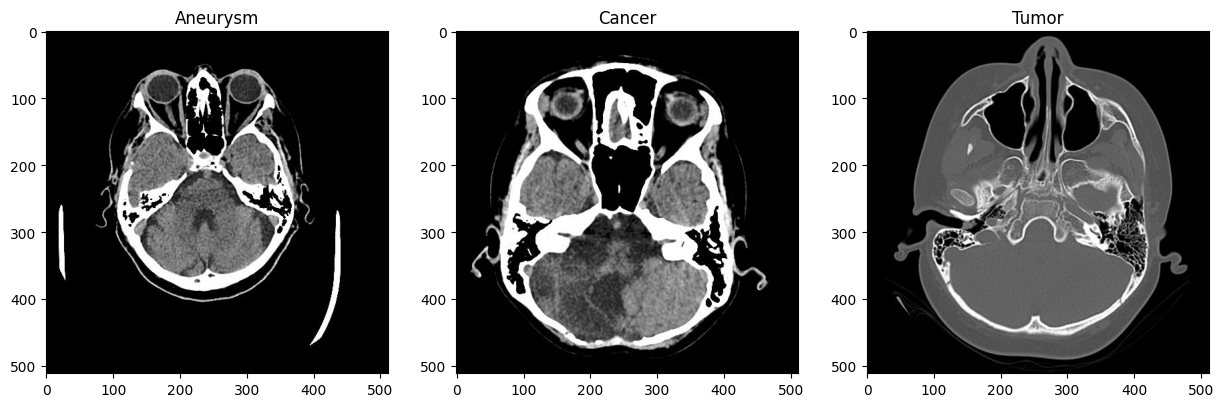

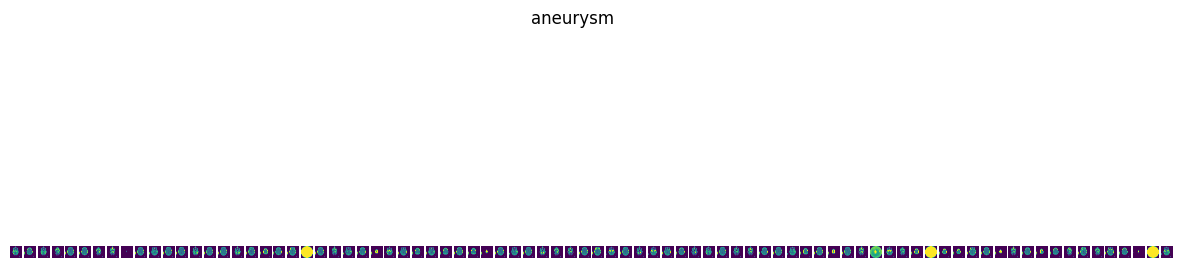

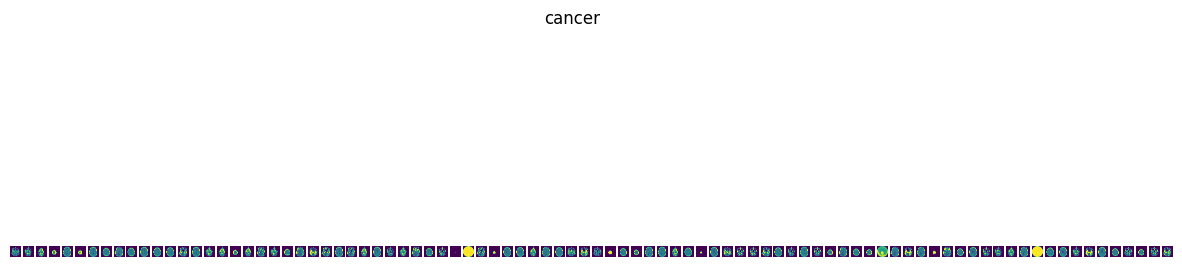

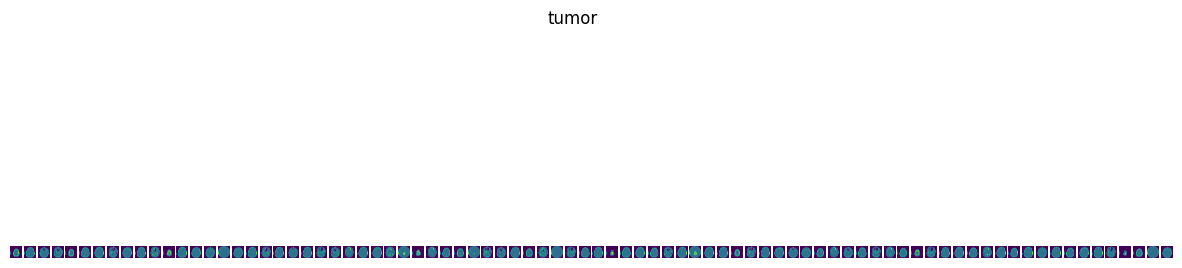

In [5]:
import random
# Visualizamos el grafico con los tipos de enfermedades cerebrales
# Assuming you have defined these variables somewhere in your code
unique_classes = ['a', 'c', 't']
images_count = [83, 90, 83]
fig = px.bar(x=unique_classes, y=images_count, color=unique_classes)
fig.update_layout(xaxis_title='Disease', yaxis_title='Count', title="Total samples for each class")
fig.update_traces(texttemplate='%{y}', textposition='inside')
fig.show()

# Visualizamos las enfermedades en formato gris
paths= ["Aneurysm","Cancer","Tumor"]
fig, axes = plt.subplots(1, num_classes, figsize=(15, 15))


for i, ax in enumerate(axes.flat):
    # Taking sample pictures from class i
    images_class_i = X_train[y_train == i]
    # Showing 5 sample images from class i
    for j in range(5):
        ax.imshow(images_class_i[j].astype('uint8'))
        ax.set_title(paths[i])
plt.show()

class_folder_names = ['aneurysm','cancer','tumor']
# Visualizamos las enfermedades en formato medico
for class_id, cls in enumerate(class_folder_names):
    class_path = os.path.join(base_dir, cls)

    # Comprobamos si es un directorio
    if os.path.isdir(class_path):
        image_files = [file for file in os.listdir(class_path) if file.endswith('.jpg')]

        if not image_files:
            print(f"Skipping...")
            continue
        images_to_display=90
        num_images_to_display = min(images_to_display, len(image_files))
        selected_images = random.sample(image_files, num_images_to_display)

        plt.figure(figsize=(15, 5))
        plt.suptitle(cls)

        for i, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to RGB color space

            plt.subplot(1, num_images_to_display, i + 1)
            plt.imshow(img)
            plt.axis('off')

        plt.show()


Definimos variables globales sobre las epocas, batch y tamaño de las imagenes

In [6]:
width_shape = height_shape = 512
num_class = 3
epocas = 20
batch_size = 32

Definimos las imagenes de entrenamiento y validacion con data augmentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
# Definimos el directorio base
#base_dir = "/content/drive/MyDrive/Colab Notebooks/"
base_dir ="archive/files/"
# En caso de usar local cambiar el directorio

# Obtener el nombre de los directorios
class_folder_names = os.listdir(base_dir)

# Creamos el dataframe con las etiquetas
df = pd.DataFrame({
    'filename': [os.path.join(base_dir, cls, file) for cls in class_folder_names for file in os.listdir(os.path.join(base_dir, cls))],
    'class': [cls for cls in class_folder_names for _ in os.listdir(os.path.join(base_dir, cls))]
})

# Iteramos sobre el dataframe
indices_to_remove = []
for index, row in df.iterrows():
    if not os.path.exists(row['filename']):
        indices_to_remove.append(index)

# Eliminamos las celdas vacias
df = df.drop(indices_to_remove, axis=0).reset_index(drop=True)

# Barajamos las imangenes
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

# Dividimos las imagenes de entrenamiento y validacion
train_df, val_df = train_test_split(df, test_size=0.2, random_state=seed)

# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

# Data augmentation para las imagenes de validacion
validation_datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

# Generador de las imagenes de entramiento modificadas
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical')

# Generador de las imagenes de validacion modificadas
validation_generator = validation_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical')


Found 207 validated image filenames belonging to 3 classes.
Found 52 validated image filenames belonging to 3 classes.


4. Creamos nuestro propio modelo a partir del modelo preentrenado VGG16

In [8]:
import torch
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# En caso de tener gpu usarla...
device = "cuda" if torch.cuda.is_available() else "cpu"

# Cargamos el modelo VGG16 sin la ultima capa
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(width_shape, height_shape, 3))

# Congelamos todas las capas para aplicar Fine Tuning
for layer in base_model.layers:
    layer.trainable = False

# Añadimos nuestras propias capas al modelo VGG16
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation='relu', kernel_regularizer=l1(0.0001))) # prevenimos sobreajuste con regulizador L1
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.0001))) # prevenimos sobreajuste con regulizador L2
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 16, 16, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 16)                2097168   
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                

5. Entrenamos nuestro modelo encima de VGG16 con las capas del VGG16 congeladas

In [9]:
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

# Definimos un early stopping para evitar sobre ajustes y minimos locales
early_stopping_phase1 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenamos el modelo
history_phase1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=4,
    validation_data=validation_generator,
    validation_steps=1,
    callbacks=[early_stopping_phase1])

Epoch 1/4


7/7 [==============================] - 90s 13s/step - loss: 2.8311 - accuracy: 0.4300 - val_loss: 1.7245 - val_accuracy: 0.4062
Epoch 2/4
7/7 [==============================] - 88s 12s/step - loss: 1.8844 - accuracy: 0.4734 - val_loss: 1.6262 - val_accuracy: 0.6875
Epoch 3/4
7/7 [==============================] - 85s 12s/step - loss: 1.5957 - accuracy: 0.5749 - val_loss: 1.4862 - val_accuracy: 0.7500
Epoch 4/4
7/7 [==============================] - 79s 12s/step - loss: 1.5866 - accuracy: 0.6280 - val_loss: 1.9875 - val_accuracy: 0.5312


Descongelamos las capas para ahora volver a seguir ejecutando el modelo pero con la capa pre entrenada

In [10]:
# Unfreeze the layers of the pretrained base
for layer in base_model.layers:
    layer.trainable = True

# Compile the model with a smaller learning rate for the second phase
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 16, 16, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 16)                2097168   
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 5

Seguimos entrenando el modelo pero con la red VGG16 pre entrenada

In [11]:
# Generador de datos de validacion
val_generator = validation_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


# Definimos un segundo early stopping para evitar sobre ajustes
early_stopping_phase2 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenamos el modelo con los datos preentrenados
history_phase2 = model.fit(
    train_generator,
    epochs=4,
    validation_data=val_generator,
    callbacks=[early_stopping_phase2])

Found 52 validated image filenames belonging to 3 classes.


Epoch 1/4
7/7 [==============================] - 522s 71s/step - loss: 1.6473 - accuracy: 0.5894 - val_loss: 1.4756 - val_accuracy: 0.6346
Epoch 2/4
7/7 [==============================] - 534s 75s/step - loss: 1.5395 - accuracy: 0.6087 - val_loss: 1.5867 - val_accuracy: 0.7308
Epoch 3/4
7/7 [==============================] - 462s 65s/step - loss: 1.4364 - accuracy: 0.6329 - val_loss: 1.4026 - val_accuracy: 0.7500
Epoch 4/4
7/7 [==============================] - 490s 69s/step - loss: 1.3672 - accuracy: 0.6618 - val_loss: 1.3061 - val_accuracy: 0.7692


6. Realizamos metricas para probar el modelo

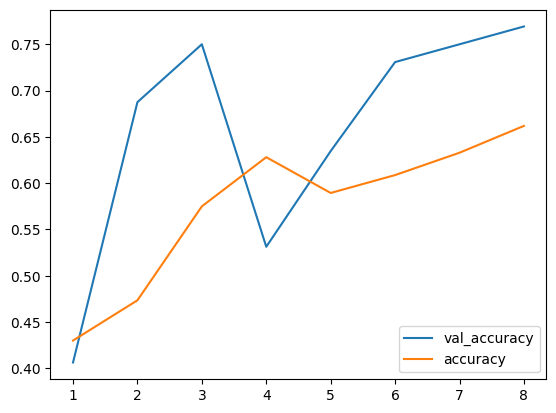

In [12]:
# Concatenamos los dos entrenamientos realizados
total_history = {
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
}

# Ajustamos el indice del segundo entrenamiento
epochs_phase2 = list(range(len(history_phase1.history['val_accuracy']) + 1, len(total_history['val_accuracy']) + 1))
history_phase2_adjusted = {
    'loss': history_phase2.history['loss'],
    'accuracy': history_phase2.history['accuracy'],
    'val_loss': history_phase2.history['val_loss'],
    'val_accuracy': history_phase2.history['val_accuracy']
}

# Ajustamos el indice del primer entrenamiento
total_history_adjusted = {
    'loss': total_history['loss'][:len(history_phase1.history['val_accuracy'])] + history_phase2_adjusted['loss'],
    'accuracy': total_history['accuracy'][:len(history_phase1.history['val_accuracy'])] + history_phase2_adjusted['accuracy'],
    'val_loss': total_history['val_loss'][:len(history_phase1.history['val_accuracy'])] + history_phase2_adjusted['val_loss'],
    'val_accuracy': total_history['val_accuracy'][:len(history_phase1.history['val_accuracy'])] + history_phase2_adjusted['val_accuracy']
}

# Mostramos la funcion de precision
epochs_total = list(range(1, len(total_history_adjusted['val_accuracy']) + 1))
plt.plot(epochs_total, total_history_adjusted['val_accuracy'], label="val_accuracy")
plt.plot(epochs_total, total_history_adjusted['accuracy'], label="accuracy")
plt.legend(loc="lower right")
plt.show()


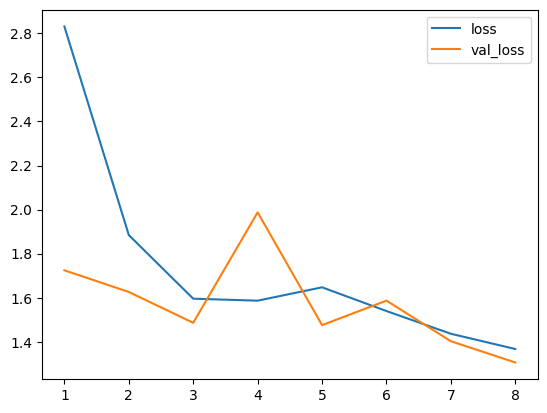

In [13]:
# Mostramos la funcion de perdida
epochs_total = list(range(1, len(total_history_adjusted['val_loss']) + 1))
plt.plot(epochs_total, total_history_adjusted['loss'], label="loss")
plt.plot(epochs_total, total_history_adjusted['val_loss'], label="val_loss")
plt.legend(loc="upper right")
plt.show()

Comprobamos el modelo con la matriz de confusion

Found 52 validated image filenames belonging to 3 classes.
2/2 [==============================] - 24s 9s/step
              precision    recall  f1-score   support

           0     0.8421    0.8000    0.8205        20
           1     0.7895    0.8333    0.8108        18
           2     1.0000    1.0000    1.0000        14

    accuracy                         0.8654        52
   macro avg     0.8772    0.8778    0.8771        52
weighted avg     0.8664    0.8654    0.8655        52



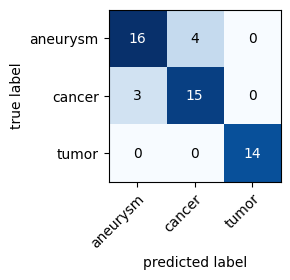

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

test_datagen = ImageDataGenerator()

prediction_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

prediction_generator = prediction_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# usamos un nuevo generador de predicciones
predictions = model.predict(x=prediction_generator, steps=len(prediction_generator))

y_pred = np.argmax(predictions, axis=1)
y_real = prediction_generator.classes

class_folder_names = ['aneurysm', 'cancer', 'tumor']

matc = confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(3,3), class_names=class_folder_names, show_normed=False)
plt.tight_layout()

print(classification_report(y_real, y_pred, digits=4))


Mostramos el funcionamiento de nuestro modelo

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Usamos un nuevo generador de predicciones
predictions = model.predict(x=prediction_generator, steps=len(prediction_generator))

y_pred = np.argmax(predictions, axis=1)
y_real = prediction_generator.classes

class_folder_names = ['aneurysm', 'cancer', 'tumor']

for p, l in zip(predictions, y_real):
    print("Predictions:", p, "->", "Actual Label:", l)
    if np.argmax(p) == l:
        print("Correct ✅")
    else:
        print("Incorrect ❌")

2/2 [==============================] - 2s 685ms/step
Predictions: [4.3300362e-03 9.9565578e-01 1.4227161e-05] -> Actual Label: 1
Correct ✅
Predictions: [0.33263227 0.33319533 0.33417234] -> Actual Label: 0
Incorrect ❌
Predictions: [9.971445e-01 2.787581e-03 6.781930e-05] -> Actual Label: 0
Correct ✅
Predictions: [0.03604723 0.08846053 0.8754923 ] -> Actual Label: 2
Correct ✅
Predictions: [0.07185896 0.90402454 0.02411652] -> Actual Label: 1
Correct ✅
Predictions: [1.372908e-05 9.422340e-04 9.990440e-01] -> Actual Label: 2
Correct ✅
Predictions: [9.9998534e-01 1.4683832e-05 1.2924095e-08] -> Actual Label: 0
Correct ✅
Predictions: [1.9209197e-03 9.9805486e-01 2.4224437e-05] -> Actual Label: 1
Correct ✅
Predictions: [9.9984825e-01 1.5108187e-04 5.8077131e-07] -> Actual Label: 0
Correct ✅
Predictions: [9.9986398e-01 1.3556221e-04 4.8658467e-07] -> Actual Label: 0
Correct ✅
Predictions: [1.6140116e-03 9.9838412e-01 1.8715308e-06] -> Actual Label: 1
Correct ✅
Predictions: [7.6548936e-04 9.99

7. Guardamos el modelo

In [87]:
from google.colab import drive
drive.mount("/content/drive")

model_save_path = "/content/drive/MyDrive/Colab Notebooks/model_cnn_ct_brain.keras"

# Save the model
model.save(model_save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
